**Identifying Ships in Satellite Images**

The dataset consists of image chips extracted from Planet satellite imagery collected over the San Franciso Bay area. It includes 2800 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.  The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within of the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image.

The "ship" class includes 700 images. Images in this class are near-centered on the body of a single ship. Ships of different ship sizes, orientations, and atmospheric collection conditions are included.  The "no-ship" class includes 2100 images. A third of these are a random sampling of different landcover features - water, vegetion, bare earth, buildings, etc. - that do not include any portion of an ship. The next third are "partial ships" that contain only a portion of an ship, but not enough to meet the full definition of the "ship" class. The last third are images that have previously been mislabeled by machine learning models, typically caused by bright pixels or string linear features. Example images from this class are shown below.

# *Step 1: Import Modules*

In [64]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import json  
# from mpl_toolkits.basemap import Basemap
# from basemap import Basemap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
# import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical

from keras.preprocessing  import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from matplotlib.pyplot import plot
# %matplotlib inline

## constants

In [65]:
gparams = {}
gparams['N_pic_train'] = 300
gparams['N_pic_test'] = 100
gparams['classifiers'] = 0
gparams['rnn'] = 1

# Pre-process

##  *Step 2: Load Data*

In [66]:
with open('../input/shipsnet.json') as data_file:
    dataset = json.load(data_file)
Shipsnet= pd.DataFrame(dataset)
print(Shipsnet.head())
print('')    
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of NoShip Images: {}'.format(np.sum(b==0)))
    print('Number of Ship Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(x,y)

                                                data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005  
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f  
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a  
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b  
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c  

Total number of images: 2800
Number of NoShip Images: 2100
Number of Ship Images: 700
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


## *Step 3: Reshape Data*

In [67]:
xReshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
yReshaped = to_categorical(y, num_classes=2)
print("Data Shape",x.shape)
print('Labels Shape',y.shape)
print('Reshaped Data Shape',xReshaped.shape)
print('Reshaped Labels Shape',yReshaped.shape)
def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(xReshaped,yReshaped)

Data Shape (2800, 19200)
Labels Shape (2800,)
Reshaped Data Shape (2800, 80, 80, 3)
Reshaped Labels Shape (2800, 2)

'X' shape: (2800, 80, 80, 3).

'y' shape: (2800, 2).

Unique elements in y: [0 1]


## *Step 4: Plot Data*

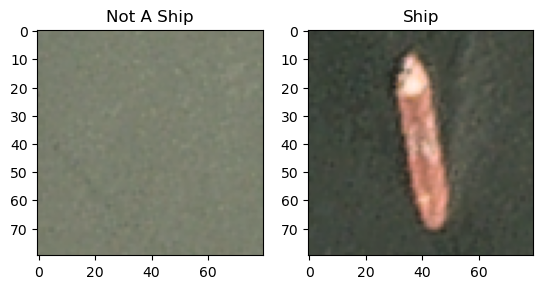

In [68]:
imgs0 = xReshaped[y==0] 
imgs1 = xReshaped[y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('Not A Ship')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('Ship')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 

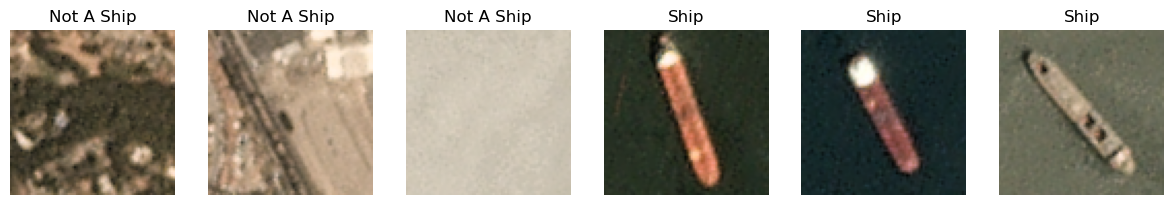

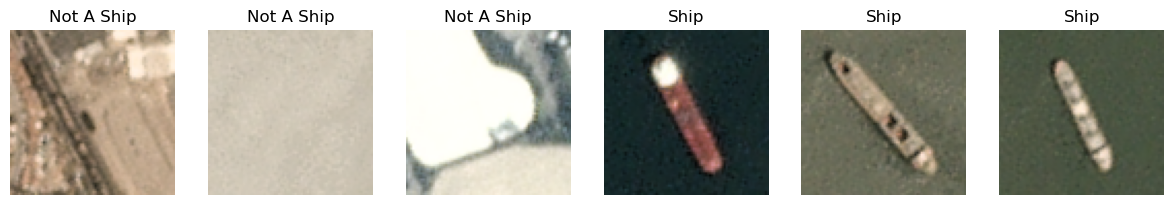

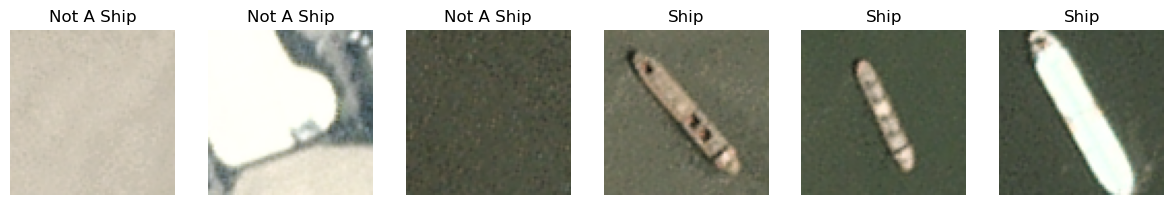

In [69]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('Not A Ship')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('Ship')
            plt.imshow(b[row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

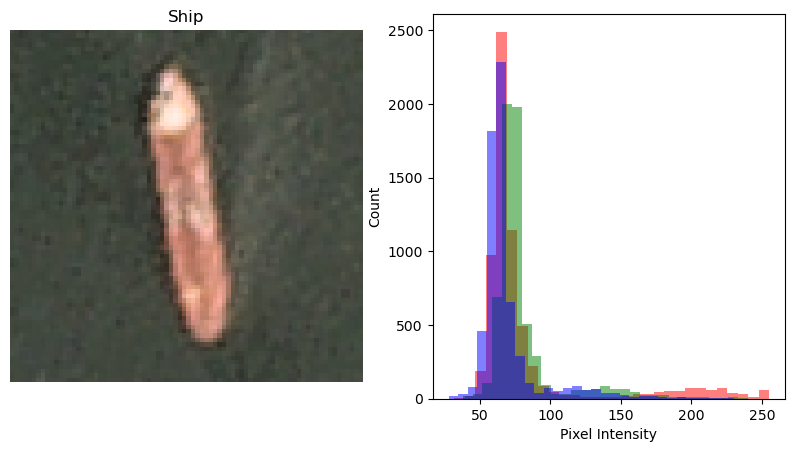

In [70]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Ship' if y[1] else 'Not A Ship')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(xReshaped[100])

## *Step 5: Preprocess Data*

In [71]:
xReshaped = xReshaped/255
# plotHistogram(xReshaped[100])

#from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 123)

# Reduce Sample Size for DeBugging
x_train = x_train[0:gparams['N_pic_train']] 
y_train = y_train[0:gparams['N_pic_train']]
x_test = x_test[0:gparams['N_pic_test']] 
y_test = y_test[0:gparams['N_pic_test']]


# x_train = x_train.reshape(x_train.shape[0],-1)
# x_test = x_test.reshape(x_test.shape[0],-1)
# y_train = y_train.reshape(y_train.shape[0],-1)

x_trainReshaped,x_testReshaped,y_trainReshaped,y_testReshaped = train_test_split(xReshaped,yReshaped,test_size = 0.2 ,random_state = 123)
# Reduce Sample Size for DeBugging
x_trainReshaped = x_trainReshaped[0:gparams['N_pic_train']] 
y_trainReshaped = y_trainReshaped[0:gparams['N_pic_train']]
x_testReshaped = x_testReshaped[0:gparams['N_pic_test']] 
y_testReshaped = y_testReshaped[0:gparams['N_pic_test']]

In [72]:
x_train.shape
y_train.shape

(300,)

# *Step 6: Compare Standard Classifiers*

In [73]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True)

In [74]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    # models.append(('LR', LogisticRegression()))
    # models.append(('RF', RandomForestClassifier()))
    # models.append(('KNN', KNeighborsClassifier()))
    # models.append(('SVM', SVC()))
    # models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('XGB', XGBClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    # models.append(('LDA', LinearDiscriminantAnalysis()))  
    resultsAccuracy = []
    names = []
    for name, model in models:
        print (name)
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=7,shuffle=True )
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
   
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
if (gparams['classifiers']):
    compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)

def defineModels():
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    print('XGB = XGBClassifier')
#    print('GBC = GradientBoostingClassifier')
#    print('LDA = LinearDiscriminantAnalysis')
    return
if (gparams['classifiers']):
    defineModels()

# *Step 7: Define Helper Functions*

In [75]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Special callback to see learning curves
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    
dict_characters = {0: 'No Ship', 1: 'Ship'}

# *Step 8: Evaluate Convolutional Network*

## create model

In [81]:
batch_size = 128
num_classes = 2
epochs = 12
#img_rows, img_cols = X_train.shape[1],X_train.shape[2]
#input_shape = (img_rows, img_cols, 3)
input_shape = (80,80,3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
model.summary()

c:\Users\gilad\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


<bound method Model.summary of <Sequential name=sequential_6, built=True>>

## image generator

In [77]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    

## fit RNN

In [78]:
history = model.fit(datagen.flow(x_trainReshaped, y_trainReshaped, batch_size=32),
                    steps_per_epoch=len(x_testReshaped) // 32, 
                    epochs=epochs, 
                    validation_data = [x_testReshaped, y_testReshaped],
                    callbacks = [MetricsCheckpoint('logs')])



Epoch 1/12


c:\Users\gilad\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.3385 - loss: 0.7395 - val_accuracy: 0.3400 - val_loss: 0.7054
Epoch 2/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.5946 - loss: 0.6829 - val_accuracy: 0.7200 - val_loss: 0.6854
Epoch 3/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - accuracy: 0.5911 - loss: 0.6652 - val_accuracy: 0.7400 - val_loss: 0.6670
Epoch 4/12
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4688 - loss: 0.7156

c:\Users\gilad\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4688 - loss: 0.7156 - val_accuracy: 0.7400 - val_loss: 0.6624
Epoch 5/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.5956 - loss: 0.6702 - val_accuracy: 0.7200 - val_loss: 0.6471
Epoch 6/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.6406 - loss: 0.6690 - val_accuracy: 0.7200 - val_loss: 0.6354
Epoch 7/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - accuracy: 0.7669 - loss: 0.6122 - val_accuracy: 0.7200 - val_loss: 0.6245
Epoch 8/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7500 - loss: 0.6241 - val_accuracy: 0.7200 - val_loss: 0.6224
Epoch 9/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.7266 - loss: 0.6099 - val_accuracy: 0.7200 - val_loss: 0.6155
Epoch 10/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.7042 - loss: 0.6231 - val_accuracy: 0.7200 - val_loss: 0.6116
Epoch 11/12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.7995 - loss: 0.5729 - val_accuracy: 0.7200 - val_loss: 0.6060
E

## RNN eval


Keras CNN #1C - accuracy: 0.7200000286102295 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

              precision    recall  f1-score   support

     No Ship       0.72      1.00      0.84        72
        Ship       0.00      0.00      0.00        28

    accuracy                           0.72       100
   macro avg       0.36      0.50      0.42       100
weighted avg       0.52      0.72      0.60       100



c:\Users\gilad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


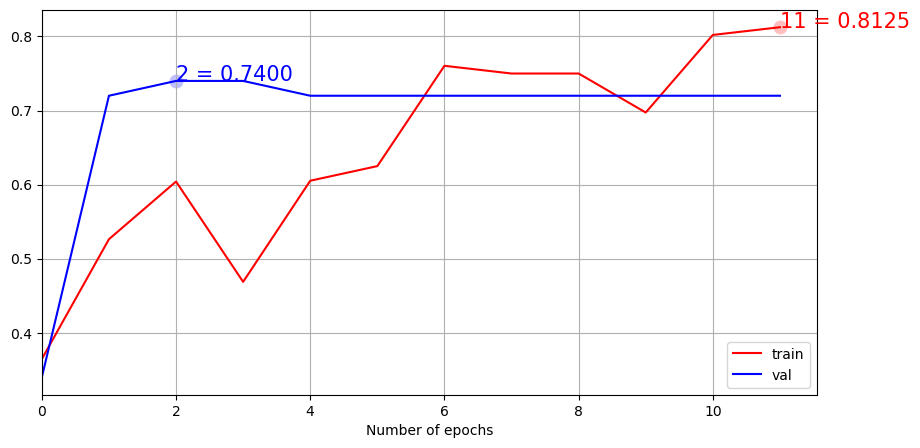

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


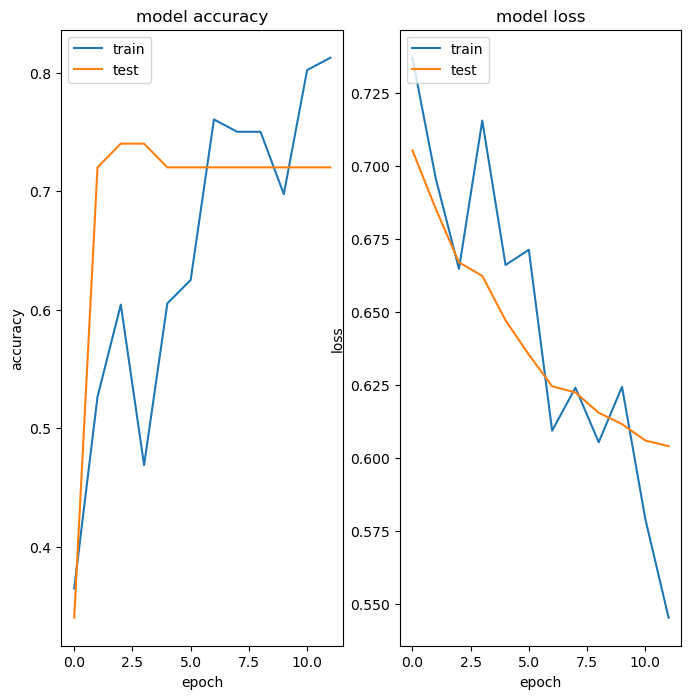

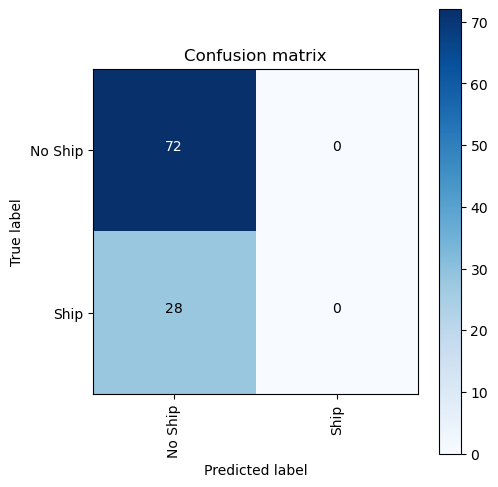

In [79]:
score = model.evaluate(x_testReshaped, y_testReshaped, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')
y_pred = model.predict(x_testReshaped)
map_characters = {0: 'No Ship', 1: 'Ship'}
print('\n', sklearn.metrics.classification_report(np.where(y_testReshaped > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
score = model.evaluate(x_testReshaped, y_testReshaped, verbose=0)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_testReshaped,axis = 1) 
plotKerasLearningCurve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()    

In [80]:
# def runKerasCNNAugment(a,b,c,d):
#     batch_size = 128
#     num_classes = 2
#     epochs = 12
#     #img_rows, img_cols = X_train.shape[1],X_train.shape[2]
#     #input_shape = (img_rows, img_cols, 3)
#     input_shape = (80,80,3)
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=input_shape))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(loss=keras.losses.categorical_crossentropy,
#                   optimizer=keras.optimizers.Adadelta(),
#                   metrics=['accuracy'])
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images
    
#     history = model.fit(datagen.flow(a,b, batch_size=32),
#                         steps_per_epoch=len(a) // 32, 
#                         epochs=epochs, 
#                         validation_data = [c, d],
#                         callbacks = [MetricsCheckpoint('logs')])
    
#     score = model.evaluate(c,d, verbose=0)
#     print('\nKeras CNN #1C - accuracy:', score[1],'\n')
#     y_pred = model.predict(c)
#     map_characters = {0: 'No Ship', 1: 'Ship'}
#     print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
#     score = model.evaluate(c,d, verbose=0)
#     Y_pred_classes = np.argmax(y_pred,axis = 1) 
#     Y_true = np.argmax(d,axis = 1) 
#     plotKerasLearningCurve()
#     plt.show()  
#     plot_learning_curve(history)
#     plt.show()
#     confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
#     plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
#     plt.show()    
# runKerasCNNAugment(x_trainReshaped, y_trainReshaped,  x_testReshaped, y_testReshaped)

With this convolutional network we were able to predict with >90% accuracy whether or not a given "image chip" contained an image of a ship.  Interestingly, we had a similar results with both XGBoost and convolutional networks.